# TFG: Machine Learning per a detecció d'intrusions a la xarxa informàtica

In [2]:
import pandas as pd
import numpy as np
import sys
import matplotlib.pyplot as plt
%matplotlib inline 
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder
import category_encoders as ce
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest,f_classif,chi2
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)

filepath='kdd-cup-1999-data/kddcup.data_10_percent'
train_df=pd.read_csv("kdd-cup-1999-data/kddcup.data_10_percent")
train_df.head()


,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,root_shell,su_attempted,num_root,num_file_creations,num_shells,num_access_files,num_outbound_cmds,is_host_login,is_guest_login,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,label
0,0,tcp,http,SF,181,5450,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,8,8,0.0,0.0,0.0,0.0,1.0,0.0,0.0,9,9,1.0,0.0,0.11,0.0,0.0,0.0,0.0,0.0,normal.
1,0,tcp,http,SF,239,486,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,8,8,0.0,0.0,0.0,0.0,1.0,0.0,0.0,19,19,1.0,0.0,0.05,0.0,0.0,0.0,0.0,0.0,normal.
2,0,tcp,http,SF,235,1337,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,8,8,0.0,0.0,0.0,0.0,1.0,0.0,0.0,29,29,1.0,0.0,0.03,0.0,0.0,0.0,0.0,0.0,normal.
3,0,tcp,http,SF,219,1337,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,6,6,0.0,0.0,0.0,0.0,1.0,0.0,0.0,39,39,1.0,0.0,0.03,0.0,0.0,0.0,0.0,0.0,normal.
4,0,tcp,http,SF,217,2032,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,6,6,0.0,0.0,0.0,0.0,1.0,0.0,0.0,49,49,1.0,0.0,0.02,0.0,0.0,0.0,0.0,0.0,normal.


# Encode Categorical Features
### methods
- LabelEncoder : canviar els strings a 0 .. n_classes
- OneHotEncoder :canviar els numeros en vectors onehot

In [3]:
#Encode categorical variables
import category_encoders as ce
service_encoder=ce.BinaryEncoder()
service_encoded=service_encoder.fit_transform(train_df['service'])


protocol_encoder=ce.OneHotEncoder()
protocol_encoded=protocol_encoder.fit_transform(train_df['protocol_type'])

#BinaryEncoder
flag_encoder=ce.BinaryEncoder()
flag_encoded=flag_encoder.fit_transform(train_df['flag'])

df=train_df.copy()

#Treure les columnes originals, posar les noves
df=pd.concat([protocol_encoded,service_encoded,flag_encoded,df],axis=1)
df=df.drop(columns=['protocol_type', 'service', 'flag'])

# Feature Scaling
### methods
- MinMaxScaler()


In [4]:
#Feature Scaling:
#Atributs que no cal escalar: discrete, rates (ja estan en rang 0-1)
non_scale_features=['protocol_type_1','protocol_type_2','protocol_type_3','service_0','service_1','service_2'
                   ,'service_3','service_4','service_5','service_6','service_7','flag_0','flag_1','flag_2','flag_3',
                   'flag_4','land','logged_in','root_shell','su_attempted','is_host_login','is_guest_login',
                   'serror_rate','srv_serror_rate', 'rerror_rate', 'srv_rerror_rate', 'same_srv_rate',
                   'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_same_srv_rate',
                   'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate',
                   'dst_host_srv_diff_host_rate', 'dst_host_serror_rate',
                   'dst_host_srv_serror_rate', 'dst_host_rerror_rate',
                   'dst_host_srv_rerror_rate']

#Atributs que necessiten reescalar: counts,nums,bytes,..
to_scale_features=['duration','src_bytes','dst_bytes','wrong_fragment','urgent','hot','num_root','num_file_creations'
                   ,'num_failed_logins','num_compromised','num_root','num_file_creations'
                   ,'num_shells','num_access_files','num_outbound_cmds','count','srv_count','dst_host_count'
                   ,'dst_host_srv_count']
scaled_df=df.copy()

In [5]:
scaled_df.describe()

,protocol_type_1,protocol_type_2,protocol_type_3,service_0,service_1,service_2,service_3,service_4,service_5,service_6,service_7,flag_0,flag_1,flag_2,flag_3,flag_4,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,root_shell,su_attempted,num_root,num_file_creations,num_shells,num_access_files,num_outbound_cmds,is_host_login,is_guest_login,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate
count,494021.000000,494021.000000,494021.000000,494021.0,494021.000000,494021.000000,494021.000000,494021.000000,494021.000000,494021.000000,494021.000000,494021.0,494021.000000,494021.000000,494021.000000,494021.000000,494021.000000,4.940210e+05,4.940210e+05,494021.000000,494021.000000,494021.000000,494021.000000,494021.000000,494021.000000,494021.000000,494021.000000,494021.000000,494021.000000,494021.000000,494021.000000,494021.000000,494021.0,494021.0,494021.000000,494021.000000,494021.000000,494021.000000,494021.000000,494021.000000,494021.000000,494021.000000,494021.000000,494021.000000,494021.000000,494021.000000,494021.000000,494021.000000,494021.000000,494021.000000,494021.000000,494021.000000,494021.000000,494021.000000
mean,0.384731,0.041201,0.574069,0.0,0.000018,0.007129,0.007109,0.828376,0.255208,0.623494,0.154506,0.0,0.002083,0.177361,0.055941,0.997972,47.979302,3.025610e+03,8.685324e+02,0.000045,0.006433,0.000014,0.034519,0.000152,0.148247,0.010212,0.000111,0.000036,0.011352,0.001083,0.000109,0.001008,0.0,0.0,0.001387,332.285690,292.906557,0.176687,0.176609,0.057433,0.057719,0.791547,0.020982,0.028997,232.470778,188.665670,0.753780,0.030906,0.601935,0.006684,0.176754,0.176443,0.058118,0.057412
std,0.486532,0.198754,0.494484,0.0,0.004268,0.084133,0.084015,0.377054,0.435978,0.484510,0.361433,0.0,0.045591,0.381974,0.229808,0.044990,707.746472,9.882181e+05,3.304000e+04,0.006673,0.134805,0.005510,0.782103,0.015520,0.355345,1.798326,0.010551,0.007793,2.012718,0.096416,0.011020,0.036482,0.0,0.0,0.037211,213.147412,246.322817,0.380717,0.381017,0.231623,0.232147,0.388189,0.082205,0.142397,64.745380,106.040437,0.410781,0.109259,0.481309,0.042133,0.380593,0.380919,0.230590,0.230140
min,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,1.000000,0.000000,4.500000e+01,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,117.000000,10.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,255.000000,46.000000,0.410000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,1.000000,0.0,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.0,0.000000,0.000000,0.000000,1.000000,0.000000,5.200000e+02,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,510.000000,510.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,255.000000,255.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,0.000000,1.000000,0.0,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.0000

In [6]:
#Scale Features
from sklearn.preprocessing import StandardScaler, MinMaxScaler
#scaler=StandardScaler()
scaler=MinMaxScaler() 

#Escalar solo los atributos necesarios
scaled_data=scaler.fit_transform(scaled_df[to_scale_features])
to_scale_df = pd.DataFrame(scaled_data, index=scaled_df[to_scale_features].index, columns=scaled_df[to_scale_features].columns)

#Asignar a la dataFrame original les columnes reescalades
scaled_df[to_scale_features]=to_scale_df
scaled_df

,protocol_type_1,protocol_type_2,protocol_type_3,service_0,service_1,service_2,service_3,service_4,service_5,service_6,service_7,flag_0,flag_1,flag_2,flag_3,flag_4,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,root_shell,su_attempted,num_root,num_file_creations,num_shells,num_access_files,num_outbound_cmds,is_host_login,is_guest_login,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,label
0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0.0,2.610418e-07,0.001057,0,0.0,0.0,0.000000,0.0,1,0.0,0,0,0.0,0.0,0.0,0.0,0.0,0,0,0.015656,0.015656,0.00,0.00,0.0,0.00,1.0,0.0,0.00,0.035294,0.035294,1.0,0.0,0.11,0.00,0.00,0.00,0.00,0.0,normal.
1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0.0,3.446905e-07,0.000094,0,0.0,0.0,0.000000,0.0,1,0.0,0,0,0.0,0.0,0.0,0.0,0.0,0,0,0.015656,0.015656,0.00,0.00,0.0,0.00,1.0,0.0,0.00,0.074510,0.074510,1.0,0.0,0.05,0.00,0.00,0.00,0.00,0.0,normal.
2,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0.0,3.389216e-07,0.000259,0,0.0,0.0,0.000000,0.0,1,0.0,0,0,0.0,0.0,0.0,0.0,0.0,0,0,0.015656,0.015656,0.00,0.00,0.0,0.00,1.0,0.0,0.00,0.113725,0.113725,1.0,0.0,0.03,0.00,0.00,0.00,0.00,0.0,normal.
3,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0.0,3.158461e-07,0.000259,0,0.0,0.0,0.000000,0.0,1,0.0,0,0,0.0,0.0,0.0,0.0,0.0,0,0,0.011742,0.011742,0.00,0.00,0.0,0.00,1.0,0.0,0.00,0.152941,0.152941,1.0,0.0,0.03,0.00,0.00,0.00,0.00,0.0,normal.
4,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0.0,3.129617e-07,0.000394,0,0.0,0.0,0.000000,0.0,1,0.0,0,0,0.0,0.0,0.0,0.0,0.0,0,0,0.011742,0.011742,0.00,0.00,0.0,0.00,1.0,0.0,0.00,0.192157,0.192157,1.0,0.0,0.02,0.00,0.00,0.00,0.00,0.0,normal.
5,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0.0,3.129617e-07,0.000394,0,0.0,0.0,0.000000,0.0,1,0.0,0,0,0.0,0.0,0.0,0.0,0.0,0,0,0.011742,0.011742,0.00,0.00,0.0,0.00,1.0,0.0,0.00,0.231373,0.231373,1.0,0.0,0.02,0.00,0.00,0.00,0.00,0.0,normal.
6,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0.0,3.057506e-07,0.000376,0,0.0,0.0,0.000000,0.0,1,0.0,0,0,0.0,0.0,0.0,0.0,0.0,0,0,0.001957,0.003914,0.00,0.00,0.0,0.00,1.0,0.0,1.00,0.003922,0.270588,1.0,0.0,1.00,0.04,0.00,0.00,0.00,0.0,normal.
7,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0.0,2.293129e-07,0.000793,0,0.0,0.0,0.000000,0.0,1,0.0,0,0,0.0,0.0,0.0,0.0,0.0,0,0,0.009785,0.009785,0.00,0.00,0.0,0.00,1.0,0.0,0.00,0.043137,0.309804,1.0,0.0,0.09,0.04,0.00,0.00,0.00,0.0,normal.
8,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0.0,3.028661e-07,0.000029,0,0.0,0.0,0.000000,0.0,1,0.0,0,0,0.0,0.0,0.0,0.0,0.0,0,0,0.015656,0.015656,0.00,0.00,0.0,0.00,1.0,0.0,0.00,0.031373,0.349020,1.0,0.0,0.12,0.04,0.00,0.00,0.00,0.0,normal.
9,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0.0,3.057506e-07,0.000152,0,0.0,0.0,0.033333,0.0,1,0.0,0,0,0.0,0.0,0.0,0.0,0.0,0,0,0.015656,0.015656,0.00,0.00,0.0,0.00,1.0,0.0,0.00,0.031373,0.388235,1.0,0.0,0.12,0.05,0.00,0.00,0.00,0.0,normal.


In [430]:
scaled_data.shape[1]
to_scale_df.head()

,duration,src_bytes,dst_bytes,wrong_fragment,urgent,hot,num_root,num_file_creations,num_failed_logins,num_compromised,num_root,num_file_creations,num_shells,num_access_files,num_outbound_cmds,count,srv_count,dst_host_count,dst_host_srv_count
0,-0.067792,-0.002879,0.138664,-0.04772,-0.002571,-0.044136,-0.00564,-0.011232,-0.009782,-0.005679,-0.00564,-0.011232,-0.009919,-0.027632,0.0,-1.521417,-1.15664,-3.451536,-1.694315
1,-0.067792,-0.002820,-0.011578,-0.04772,-0.002571,-0.044136,-0.00564,-0.011232,-0.009782,-0.005679,-0.00564,-0.011232,-0.009919,-0.027632,0.0,-1.521417,-1.15664,-3.297085,-1.600011
2,-0.067792,-0.002824,0.014179,-0.04772,-0.002571,-0.044136,-0.00564,-0.011232,-0.009782,-0.005679,-0.00564,-0.011232,-0.009919,-0.027632,0.0,-1.521417,-1.15664,-3.142633,-1.505707
3,-0.067792,-0.002840,0.014179,-0.04772,-0.002571,-0.044136,-0.00564,-0.011232,-0.009782,-0.005679,-0.00564,-0.011232,-0.009919,-0.027632,0.0,-1.530800,-1.16476,-2.988182,-1.411403
4,-0.067792,-0.002842,0.035214,-0.04772,-0.002571,-0.044136,-0.00564,-0.011232,-0.009782,-0.005679,-0.00564,-0.011232,-0.009919,-0.027632,0.0,-1.530800,-1.16476,-2.833731,-1.317100


In [ ]:
attacks_cat=['DOS','R2L','U2R','probe']
attacks={'DOS':['back.','land.','neptune.','smurf.','teardrop.','pod.'],
         'R2L':['ftp_write.','guess_passwd.','imap.','multihop.','phf.','warezclient.','warezmaster.','spy.'],
         'U2R':['buffer_overflow.','loadmodule.','perl.','rootkit.'],
         'probe':['ipsweep.','nmap.','portsweep.','satan.']}

def label_categoria(val):
    val2=0
    if val == 'normal.':
        val2='normal.'
        return val2
    val2='unknown.'
    for i in attacks_cat:
        if val in attacks[i]:
            val2=i
            break
    return val2

def label_atac(val):
    if val == 'normal.':
        return val
    else:
        return 'atac'

df2=scaled_df.copy()
df2['label2']=[label_categoria(i) for i in df2['label']] #create a second label column with 4 main categories attacks
df2['label3']=[label_atac(i) for i in df2['label2']] # Crear 3r label per detectar si es atac o no

# Feature Selection
Calcular amb la funció f_classif, chi2

In [432]:
from sklearn.feature_selection import SelectKBest,f_classif,chi2

#Tots els atributs menys la columna 'label'
v=list(df.columns)
v.remove('label')

model_classif=SelectKBest(f_classif,k=20)
selected_df=model_classif.fit_transform(df[v],df['label'])

#Score function : f_classif
for i,j in sorted(list(zip(v,model_classif.scores_)),key= lambda x:x[1],reverse=True): 
    print('{0} -> {1:.6f}'.format(i,j))

//anaconda/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:114: UserWarning: Features [ 3 11 32 33] are constant.
  UserWarning)
//anaconda/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:115: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


service_0 -> nan
flag_0 -> nan
wrong_fragment -> 4945859.554635
num_outbound_cmds -> nan
is_host_login -> nan
srv_count -> 4618692.334943
protocol_type_3 -> 1889119.605515
same_srv_rate -> 1075342.467531
count -> 712733.485227
land -> 471526.624514
dst_host_same_src_port_rate -> 288259.252786
dst_host_same_srv_rate -> 173323.312168
dst_host_srv_count -> 137938.887955
protocol_type_1 -> 137066.027549
service_6 -> 107359.710861
service_5 -> 90967.415566
flag_2 -> 74996.313399
dst_host_serror_rate -> 73608.645865
serror_rate -> 73455.037875
dst_host_srv_serror_rate -> 73251.647894
srv_serror_rate -> 73050.205158
service_4 -> 62201.592650
logged_in -> 48732.576185
flag_1 -> 39614.947913
service_7 -> 38548.305104
flag_4 -> 32682.520232
dst_host_srv_diff_host_rate -> 32546.841865
dst_bytes -> 30106.544837
num_failed_logins -> 22279.598268
diff_srv_rate -> 20957.823694
dst_host_count -> 20521.952620
dst_host_diff_srv_rate -> 14437.840251
root_shell -> 12603.684439
hot -> 7343.698022
protocol_

In [423]:
#Score function : chi2
model_chi2=SelectKBest(chi2,k=20)
selected_df=model_chi2.fit_transform(df[discrete_features],df['label'])


#Ordenar per la puntuació
for i,j in sorted(list(zip(discrete_features,model_chi2.scores_)),key= lambda x:x[1],reverse=True): 
    print('{0} -> {1:.6f}'.format(i,j))

service_0 -> nan
flag_0 -> nan
land -> 471543.730838
is_host_login -> nan
wrong_fragment -> 1389256.353529
num_failed_logins -> 390354.024997
flag_1 -> 314645.407045
flag_2 -> 312758.712985
service_5 -> 295100.263756
logged_in -> 288056.519946
num_compromised -> 265185.525251
service_7 -> 263944.102661
protocol_type_1 -> 261170.483706
protocol_type_3 -> 207947.296722
root_shell -> 177584.771124
num_actions -> 169414.618980
service_6 -> 153828.520000
num_root -> 139757.064201
protocol_type_2 -> 95694.359684
num_file_creations -> 78289.132354
is_guest_login -> 67905.453411
flag_3 -> 67289.621385
service_4 -> 62297.076336
num_shells -> 60166.239963
su_attempted -> 13786.342816
service_3 -> 9197.900706
service_2 -> 8232.057170
num_access_files -> 8177.716567
service_1 -> 5198.060755
flag_4 -> 593.936925
num_outbound_cmds -> nan


In [7]:
#Quedarse amb els atributs finals
features=df.columns.tolist()
drop_features=['label','num_outbounds_cmds','is_host_login','service_0','flag_0',
              'num_root','service_1','su_attempted','urgent','num_shells',
              'root_shell']
selected_features=[i for i in features if i not in drop_features]



In [8]:
from sklearn.metrics import confusion_matrix

# Entrenar el model amb split kfold
def model_train(model,X,y,n_splits=4):
    skf=StratifiedKFold(n_splits=n_splits)
    scores = []
    for train_index,test_index in skf.split(X,y):
        X_train,X_test=X.iloc[train_index],X.iloc[test_index]
        y_train,y_test=y.iloc[train_index],y.iloc[test_index]
        model.fit(X_train,y_train)
        score=model.score(X_test,y_test)
        print('Puntuacio: {:.6f}'.format(score))
        scores.append(score)
    print('Puntuació mitjana: {:.6f}'.format(np.mean(scores)))
    cm_show(model,X_test,y_test)

#Funció per mostrar grafica de confusion matrix
def cm_show(model,X_test,y_test):
    labels = y_test.unique().tolist()
    pred = model.predict(X_test)
    cm = confusion_matrix(y_test, pred, labels)
    print(cm)
    ax= plt.subplot()
    sns.heatmap(cm,fmt='g', annot=True, ax = ax); #annot=True to annotate cells

    # labels, title and ticks
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels')
    ax.set_title('Confusion Matrix')
    ax.xaxis.set_ticklabels(labels); ax.yaxis.set_ticklabels(labels);

# Funcion per mantenir la mateixa proporcio de mostres de cada classe
def same_percentage_each_class(X,y):
    labels = y.unique()
    max_samples = min([i for i in y.value_counts()])
    indices = np.array([])
    
    for label in labels:
        index = y[y == label].index.values
        np.random.shuffle(index)
        index =  index[0:max_samples]
        indices = np.concatenate((indices,index), axis=0)    
    np.random.shuffle(indices)
    return X.iloc[indices],y.iloc[indices]



# Decision Trees

Puntuacio: 0.996885
Puntuacio: 0.999326
Puntuacio: 0.865169
Puntuació mitjana: 0.953793
[[ 31181    950    233     57      5]
 [    12    363      0      0      0]
 [    80    262   1027      0      0]
 [    41      0  20557 109888      0]
 [     5      1      0      0     11]]
CPU times: user 9.44 s, sys: 790 ms, total: 10.2 s
Wall time: 6.39 s


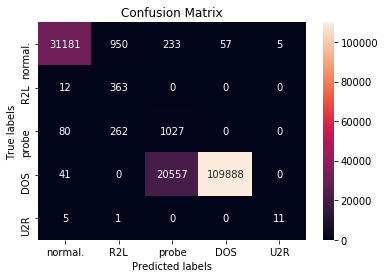

In [300]:
%%time
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import StratifiedKFold

X=df[selected_features]
y=df2['label2' ]

#X,y = same_percentage_each_class(X,y) #Mantenir amb el mateix percentatge en 50% atac/normal

model = DecisionTreeClassifier()

model_train(model,X,y,3)


Puntuacio: 0.999065
Puntuacio: 0.999106
Puntuació mitjana: 0.999085
[[48613    26]
 [   61 48578]]
CPU times: user 10.4 s, sys: 1.82 s, total: 12.2 s
Wall time: 2.84 s


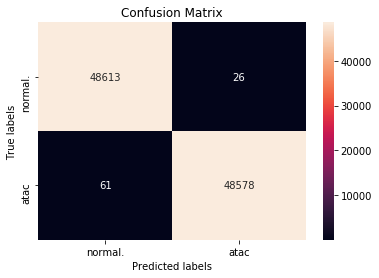

In [13]:
%%time
#Gradient Boosting
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score

X=df[selected_features]
y=df2['label3']

X,y = same_percentage_each_class(X,y)

lgbm=LGBMClassifier(learning_rate=0.1,n_estimators=20)

model_train(lgbm,X,y,2)


SVC:
Puntuacio: 0.993547
Puntuacio: 0.905751
Puntuació mitjana: 0.949649
[[    25      0      0      0      0      0      0      0      0      1
       0      0      0      0      0      0      0      0      0      0
       0      0      0]
 [     0      0      0      0      0      0      0      0      0      1
       0      0      0      0      3      0      0      0      0      0
       0      0      0]
 [     0      0     56      0      0      0      0      0      0   1045
       0      0      0      0      0      0      0      0      0      0
       0      0      0]
 [     0      0      0    541      0      0      0      0      0     82
       0      0      0      0      0      0      0      0      0      0
       0      0      0]
 [     0      0      0      0      0      0      0      0      0      1
       0      0      0      0      2      0      0      0      0      0
       0      0      0]
 [     0      0      0     99      0      0      0      0      0     16
       0      0

//anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


CPU times: user 5min 11s, sys: 3.78 s, total: 5min 14s
Wall time: 5min 15s


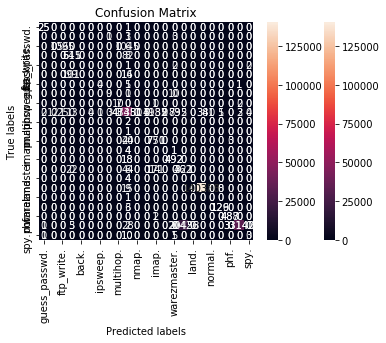

In [303]:
%%time
#Support Vector Machine
from sklearn.svm import SVC
from sklearn.svm import LinearSVC

X=scaled_df[selected_features]
y=df2['label']

#X,y = same_percentage_each_class(X,y)

svc=SVC(kernel='rbf',gamma='auto')
linear_svc=LinearSVC()

#one vs rest multiclass
print("SVC:") 
model_train(svc,X,y,2)


#one vs one multiclass 
print("LinearSVC:")
model_train(linear_svc,X,y,2)


# Multiples Classificadors

Classificador atac/normal <br>
    if atac : Classificador dos/u2r/r2l/probe <br>
        if dos : Clf dos <br>
        elif u2r : clf u2r <br>
        elif r2l : clf r2l <br> 
        elif probe : clf probe <br>
        

In [288]:
from sklearn.base import clone
class ClassifierMultiple():
    def __init__(self,model):
        self.clf = clone(model) # normal/atac
        self.clf_atac = clone(model) #dos/u2r/r2l/probe
        self.clf_dict = { # diccionari amb els 4 tipus d'atac
            'DOS':clone(model),
            'R2L':clone(model),
            'U2R':clone(model),
            'probe':clone(model)
        }

    def train(self,data):
        #Entrenar amb dades X a cada clasificador
        self.model_train(self.clf,data,'label3') # atac/normal
        
        data_train = data[data['label3'] == 'atac']
        self.model_train(self.clf_atac,data_train,'label2') # dos/u2r/r2l/probe
        
        data_train = data[data['label2'] == 'DOS']
        self.model_train(self.clf_dict['DOS'],data_train,'label') # dos atacs
        
        data_train = data[data['label2'] == 'R2L']
        self.model_train(self.clf_dict['R2L'],data_train,'label') # r2l atacs
        
        data_train = data[data['label2'] == 'U2R']
        self.model_train(self.clf_dict['U2R'],data_train,'label') # u2r atacs
        
        data_train = data[data['label2'] == 'probe']
        self.model_train(self.clf_dict['probe'],data_train,'label') # probe atacs
        
    def model_train(self,model,data,label_name):
        X = data[selected_features]
        y = data[label_name]
        model.fit(X,y)
    def score(self,predicted,y_test):
        index = y_test.index
        pred = pd.DataFrame(predicted, index=index)
        results = pd.concat([y_test,pred], axis=1, ignore_index=True)
        return accuracy_score(results[0],results[1])
    def predict(self,X_test):
        old_indices = X_test.index
        X = X_test.reset_index(drop=True) #restaurar els indices de 0 a n

        results = pd.Series([])
        X_indices = X.index
        preds_3 = self.clf.predict(X.iloc[:]) # predir si son normal/atac
        preds_3 = pd.Series(preds_3, index=X_indices,name='preds_3') # Canviar els indexs dels valors predicts
        
        # guardar com a resultat final els que tenen etiqueta 'normal'
        results = pd.concat([results,preds_3[preds_3 == 'normal.']],axis=0) 
        
        X_test_3 = preds_3[preds_3 == 'atac'] # continuar classificar amb els atacs
        indices_3 = X_test_3.index # guardar els indices que son 'atac'
        
        preds_2 = self.clf_atac.predict(X.iloc[indices_3]) # dóna prediccions de dos/r2l/u2r/probe
        preds_2 = pd.Series(preds_2, index=indices_3,name='preds_2') # reestaurar els indices

        for atac_type in self.clf_dict.keys():
            preds_1 = preds_2[preds_2 == atac_type]
            indices_1 = preds_1.index
            preds = self.clf_dict[atac_type].predict(X.iloc[indices_1])
            preds = pd.Series(preds, index=indices_1,name='preds_1')
            results = pd.concat([results,preds],axis=0)
        
        results = results.sort_index() # ordenar per el index
        return results



In [294]:
# Decision Tree
from sklearn.model_selection import train_test_split
X=df2[selected_features]
y=df2

X_train, X_test = train_test_split(df2, test_size=0.25)

model = DecisionTreeClassifier()
clf_multiple = ClassifierMultiple(model)
clf_multiple.train(X_train)
predict = clf_multiple.predict(X_test[selected_features])
accuracy_score(predict,X_test['label'])

0.9996923226401956

In [298]:
# Gradien Boosting
from sklearn.model_selection import train_test_split
X=df2[selected_features]
y=df2

X_train, X_test = train_test_split(df2, test_size=0.25)

model = LGBMClassifier(learning_rate=0.01,n_estimators=100)
clf_multiple = ClassifierMultiple(model)
clf_multiple.train(X_train)
predict = clf_multiple.predict(X_test[selected_features])
accuracy_score(predict,X_test['label'])

0.998477806746231

In [679]:
#v=['duration','src_bytes','dst_bytes','land','wrong_fragment','urgent']
#v=['hot','num_failed_logins','logged_in','num_compromised','root_shell','su_attempted','num_root',
#'num_file_creations','num_shells','num_access_files','num_actions','num_outbound_cmds','is_host_login','is_guest_login']
#v=['count','srv_count','serror_rate','srv_serror_rate','rerror_rate','srv_rerror_rate',
#'same_srv_rate','diff_srv_rate','srv_diff_host_rate']
v=['dst_host_count','dst_host_srv_count','dst_host_same_srv_rate',
'dst_host_diff_srv_rate','dst_host_same_src_port_rate','dst_host_srv_diff_host_rate','dst_host_serror_rate',
'dst_host_srv_serror_rate','dst_host_rerror_rate','dst_host_srv_rerror_rate']

#pivot table per analitzar dades per label
pd.pivot_table(df2,index=['label2','label'],values=v,aggfunc=np.mean)


dst_host_count  dst_host_diff_srv_rate  \
label2  label                                                      
DOS     back.                 206.963686                0.000000   
        land.                   2.904762                0.026667   
        neptune.              254.729965                0.066121   
        pod.                   66.617424                0.110682   
        smurf.                254.981506                0.000034   
        teardrop.             239.316650                0.202829   
R2L     ftp_write.              1.500000                0.250000   
        guess_passwd.          26.018868                0.000000   
        imap.                  26.750000                0.000833   
        multihop.              74.000000                0.002857   
        phf.                  255.000000                0.007500   
        spy.                  255.000000                0.020000   
        warezclient.           84.466667                0.019108   
        warezmaster.           32.200000                0.004000   
U2R     buffer_overflow.        3.066667                0.000000   
        loadmodule.             2.666667                0.205556   
        perl.                 193.000000                0.030000   
        rootkit.              178.900000                0.014000   
normal. normal.               148.512130                0.056479   
probe   ipsweep.                3.947073                0.073777   
        nmap.                 114.926407                0.439177   
        portsweep.            249.952885                0.764692   
        satan.                253.350535                0.903304   

                          dst_host_rerror_rate  dst_host_same_src_port_rate  \
label2  label                                                                 
DOS     back.                         0.050390                     0.010281   
        land.                         0.006190                     0.870000   
        neptune.                      0.190831                     0.000082   
        pod.                          0.000758                     0.659735   
        smurf.                        0.000028                     0.999693   
        teardrop.                     0.220061                     0.246834   
R2L     ftp_write.                    0.000000                     0.875000   
        guess_passwd.                 0.879245                     0.105283   
        imap.                         0.002500                     0.625000   
        multihop.                     0.011429                     0.714286   
        phf.                          0.000000                     0.000000   
        spy.                          0.000000                     0.000000   
        warezclient.                  0.003961                     0.661304   
        warezmaster.                  0.006000                     0.900000   
U2R     buffer_overflow.              0.021333                     0.680667   
        loadmodule.                   0.000000                     0.735556   
        perl.                         0.230000                     0.003333   
        rootkit.                      0.073000                     0.250000   
normal. normal.                       0.057717                     0.133952   
probe   ipsweep.                      0.069118                     0.930281   
        nmap.                         0.000000                     0.959784   
        portsweep.                    0.890173                     0.887327   
        satan.                        0.780302                     0.073505   

                          dst_host_same_srv_rate  dst_host_serror_rate  \
label2  label                                                            
DOS     back.                           1.000000              0.002138   
        land.                           0.870000              0.893810   
        neptune.                        0.043327     

atac       64852
normal.    64852
Name: label3, dtype: int64
atac       64852
normal.    64852
Name: label3, dtype: int64
atac       64852
normal.    64852
Name: label3, dtype: int64


In [337]:
#import pickle
#Per Guardar els models entrenats
#filename = 
#pickle.dump(model, open(filename, 'wb'))
 
#some time later...
 
# load the model from disk
#loaded_model = pickle.load(open(filename, 'rb'))


In [ ]:
#llistes d'atributs per tipus de contingut
basic_features=['duration','protocol_type','service','flag','src_bytes','dst_bytes','land','wrong_fragment','urgent']

content_features=['hot','num_failed_logins','logged_in','num_compromised','root_shell','su_attempted','num_root',
'num_file_creations','num_shells','num_access_files','num_outbound_cmds','is_host_login','is_guest_login']

traffic_features=['count','srv_count','serror_rate','srv_serror_rate','rerror_rate','srv_rerror_rate',
'same_srv_rate','diff_srv_rate','srv_diff_host_rate','dst_host_count','dst_host_srv_count','dst_host_same_srv_rate',
'dst_host_diff_srv_rate','dst_host_same_src_port_rate','dst_host_srv_diff_host_rate','dst_host_serror_rate',
'dst_host_srv_serror_rate','dst_host_rerror_rate','dst_host_srv_rerror_rate']

In [420]:
all_features=['duration',
'protocol_type',
'service',
'flag',
'src_bytes',
'dst_bytes',
'land',
'wrong_fragment',
'urgent',
'hot',
'num_failed_logins',
'logged_in',
'num_compromised',
'root_shell',
'su_attempted',
'num_root',
'num_file_creations',
'num_shells',
'num_access_files',
'num_outbound_cmds',
'is_host_login',
'is_guest_login',
'count',
'srv_count',
'serror_rate',
'srv_serror_rate',
'rerror_rate',
'srv_rerror_rate',
'same_srv_rate',
'diff_srv_rate',
'srv_diff_host_rate',
'dst_host_count',
'dst_host_srv_count',
'dst_host_same_srv_rate',
'dst_host_diff_srv_rate',
'dst_host_same_src_port_rate',
'dst_host_srv_diff_host_rate',
'dst_host_serror_rate',
'dst_host_srv_serror_rate',
'dst_host_rerror_rate',
'dst_host_srv_rerror_rate',
'label']

discrete_features=['protocol_type_1','protocol_type_2','protocol_type_3','service_0','service_1','service_2'
                   ,'service_3','service_4','service_5','service_6','service_7','flag_0','flag_1','flag_2','flag_3',
                   'flag_4','land','logged_in','is_host_login','is_guest_login','root_shell',
                  'su_attempted',
                  'num_failed_logins','wrong_fragment','num_actions',
                'num_compromised','num_root','num_file_creations','num_shells','num_access_files','num_outbound_cmds']
continuous_features=['duration','src_bytes','dst_bytes','flag','wrong_fragment','urgent','hot','num_failed_logins',
                     'num_compromised','num_root','num_file_creations','num_shells','num_access_files','num_outbound_cmds'
                     'count','srv_count','serror_rate','srv_serror_rate',
'rerror_rate','srv_rerror_rate','same_srv_rate','diff_srv_rate','srv_diff_host_rate','dst_host_count',
'dst_host_srv_count','dst_host_same_srv_rate','dst_host_diff_srv_rate','dst_host_same_src_port_rate',
'dst_host_srv_diff_host_rate','dst_host_serror_rate','dst_host_srv_serror_rate','dst_host_rerror_rate',
'dst_host_srv_rerror_rate']